# <center>Feature Classifier (using VGG16 or ResNet50)<center>

- This file aims to replicate the process done in [*Parkinson Disease Identification using Residual Networks and OPF* by Passos et al.](../Literature/dataset-papers/Passos_etal_22.pdf)
- Use pretrained models to extract features from dataset 
- This is done by importing pretrained model (either VGG16 or ResNet50) and excluding the top layers (fully connected layers).
- After the extracted features are caculated, can run these through as inputs through a global average pooling layer and FC layer to get classification output.


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import cv2
import PIL

# import ML/DL libraries
from sklearn.model_selection import train_test_split
from sklearn import utils # used to shuffle data

from keras.preprocessing.image import ImageDataGenerator # used for image augmentation


import tensorflow as tf
# used for building and training a new model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16, ResNet50

# import functions from other python files
from code_files.imagePreprocessing import * 

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # disabling the GPU allows the model here to run

In [5]:
# import images (and labels) and store in dataframe
data_path = 'datasets/handPD_orig/'  #'datasets/folador_spiral/'   

trainImgs = pd.DataFrame()
testImgs  = pd.DataFrame()
trainArray = []
testArray  = []


for dataType in os.listdir(data_path):
    img_path = []
    lbl = []
    lblName = []
    for group in os.listdir(os.path.join(data_path, dataType)):
        for img in os.listdir(os.path.join(data_path, dataType, group)):
            path = os.path.join(data_path, dataType, group, img)
            img_path.append(path) 

            # convert the image and store as a matrix
            drawing = cv2.imread(path)
            drawing = cv2.resize(drawing, (224,224))

            if dataType == 'test':
                testArray.append(drawing)
            else:
                trainArray.append(drawing)

            # store the labels
            if group == 'healthy':
                lbl.append(0)
                lblName.append('healthy')
            else:
                lbl.append(1)
                lblName.append('parkinsons')

    if dataType == 'train':
        trainLbls = lbl
        trainImgs['image'] = img_path
        trainImgs['label'] = lblName
    else:
        testLbls = lbl
        testImgs['image'] = img_path
        testImgs['label'] = lblName

# shuffle the data
trainImgs, trainArray, trainLbls = utils.shuffle(trainImgs, trainArray, trainLbls)
# testImgs, testArray, testLbls = utils.shuffle(testImgs, testArray, testLbls)

# convert labels to categorical for training model
trainLbls_categorical = tf.keras.utils.to_categorical(trainLbls)
print("Labels of first 5 images: \n", trainLbls_categorical[0:5])

train_feat, test_feat, train_lbls, test_lbls = train_test_split(trainArray, trainLbls, test_size=0.2, random_state=42)
trainArray, testArray, _,_ = train_test_split(trainArray, trainLbls, test_size=0.2, random_state=42)

Labels of first 5 images: 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [3]:
# display first five images
print("Lables of first train 5 images: ", trainLbls[0:5])
trainImgs.head()

Lables of first train 5 images:  [1, 0, 0, 1, 0]


,image,label
146,datasets/handPD_new/train\parkinsons\sp1-P29.jpg,parkinsons
35,datasets/handPD_new/train\healthy\sp2-H13.jpg,healthy
27,datasets/handPD_new/train\healthy\sp1-H38.jpg,healthy
235,datasets/handPD_new/train\parkinsons\sp4-P32.jpg,parkinsons
93,datasets/handPD_new/train\healthy\sp3-H7.jpg,healthy


In [6]:
print("Test labels: ", testLbls)
display(testImgs)

Test labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


,image,label
0,datasets/handPD_new/test\healthy\sp1-H1.jpg,healthy
1,datasets/handPD_new/test\healthy\sp1-H18.jpg,healthy
2,datasets/handPD_new/test\healthy\sp1-H9.jpg,healthy
3,datasets/handPD_new/test\healthy\sp2-H11.jpg,healthy
4,datasets/handPD_new/test\healthy\sp2-H20.jpg,healthy
5,datasets/handPD_new/test\healthy\sp2-H3.jpg,healthy
6,datasets/handPD_new/test\healthy\sp3-H13.jpg,healthy
7,datasets/handPD_new/test\healthy\sp3-H22.jpg,healthy
8,datasets/handPD_new/test\healthy\sp3-H5.jpg,healthy
9,datasets/handPD_new/test\healthy\sp4-H16.jpg,healthy


## <center> Extract features using pretrained model <center>

In [6]:
# create the convolutional base network for VGG16
# output of this will be feature vectors for each image
VGG16_conv_base = ResNet50(weights='imagenet', include_top=True) # setting include_top=False removes the fully connected layers of the model
VGG16_conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# input_layer = tf.keras.Input(shape=(256,256,3))
Layer1 = VGG16_conv_base
Layer2 = GlobalAveragePooling2D()(Layer1)
output_layer = Dense(2, activation='softmax')(Layer2)
model = tf.keras.models.Model(inputs=[VGG16_conv_base.inputs], outputs=VGG16_conv_base.get_layer('input_1'))
model.summary()

In [8]:
# define a function that will extract the features from conv network
def extract_features(imgs, num_imgs):
    datagen = ImageDataGenerator(rescale=1./255) # define to rescale pixels in image
    batch_size = 10
    
    features = np.zeros(shape=(num_imgs, 8,8,512)) # shape equal to output of convolutional base
    lbls = np.zeros(shape=(num_imgs,2))

    # preprocess data
    generator = datagen.flow_from_dataframe(imgs, x_col = 'image', y_col='label', target_size=(256,256), class_mode='categorical', batch_size=batch_size)

    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = VGG16_conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        lbls[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= num_imgs:
            break
    return features, lbls

In [9]:
# extract features for both the trainImgs and testImgs
train_feat, train_lbls = extract_features(trainImgs, 240)
test_feat, test_lbls = extract_features(testImgs, 24)

Found 240 validated image filenames belonging to 2 classes.
1/1 [==============================] - 8s 8s/step


In [3]:
# evaluate on VGG16 classifier (using cross validation)
# define a function that will fit the model
def defineModel(size): # size is the dimension of the last layer in the pretrained model
    vgg16_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
    base_model = tf.keras.models.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block5_pool').output) # conv5_block3_out
    base_out = base_model.output
    top_fc1 = GlobalAveragePooling2D()(base_out)
    top_fc2 = Flatten()(top_fc1)
    top_preds = Dense(2, activation="softmax")(top_fc2)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=top_preds)
    model.summary()

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)  # use the Adam optimizer and set an effective learning rate 
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = defineModel(8)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [4]:
# train the model using cross validation
# will start with k-fold cross validation, taking 80% as training each fold

# define model checkpoint callback
model_chkpt = tf.keras.callbacks.ModelCheckpoint('20221202_vgg16_1fold_handPD_orig_rs42.h5', save_best_only=True)

def fit_and_evaluate(train_feat, train_lbls, val_feat, val_lbls, epochs):
    model = None
    model = defineModel(8)
    trained_model = model.fit(train_feat, train_lbls, batch_size=32, epochs=epochs, validation_data=(val_feat, val_lbls), callbacks=model_chkpt)

    # testScore = model.evaluate(test_feat, test_lbls)
    return trained_model

In [6]:
# train with k-fold validation
model_history = []
epochs = 15

num_val_samples = int(np.ceil(len(trainArray) * 0.20))
k = int(np.floor(len(trainArray) / num_val_samples))

for i in range(k):
    print("Training on fold K = ", i+1)
    startPt = i * num_val_samples
    endPt   = (i+1) * num_val_samples

    
    val_x = np.array(train_feat[startPt:endPt])
    val_y = tf.keras.utils.to_categorical(train_lbls[startPt:endPt])
    train_x = np.delete(train_feat, np.linspace(startPt, endPt-1, num_val_samples).astype(np.int), axis=0)
    train_y = tf.keras.utils.to_categorical(np.delete(train_lbls, np.linspace(startPt, endPt-1, num_val_samples).astype(np.int), axis=0))

    model_history.append(fit_and_evaluate(train_x, train_y, val_x, val_y, epochs=epochs))
    # print(model_history)
    
    print("======="*12, end="\n")
    

Training on fold K =  1
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None,

KeyboardInterrupt: 

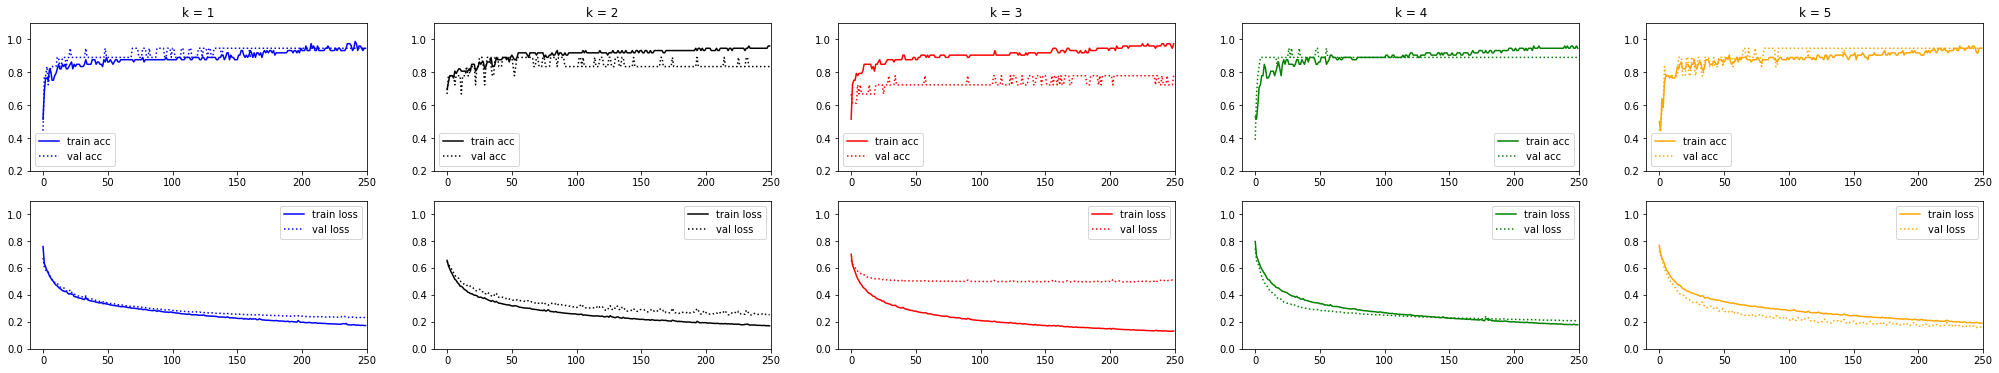

In [11]:
# plot the accuracy and loss functions for each fold
color = ['blue', 'black', 'red', 'green','orange', 'cyan', 'grey', 'yellow', 'fuchsia']
f, ax = plt.subplots(2, k, figsize=(35,6))
for i in range(k):
    ax[0][i].plot(model_history[i].history['accuracy'], label='train acc', color=color[i])
    ax[0][i].plot(model_history[i].history['val_accuracy'], label='val acc', linestyle= ':', color=color[i])
    ax[0][i].axis([-10,epochs, .2, 1.1])
    ax[0][i].legend()

    subplot_title = 'k = ' + str(i+1)
    ax[0][i].title.set_text(subplot_title)

for i in range(k):
    ax[1][i].plot(model_history[i].history['loss'], label='train loss', color=color[i])
    ax[1][i].plot(model_history[i].history['val_loss'], label='val loss', linestyle= ':', color=color[i])
    ax[1][i].axis([-10,epochs, .0, 1.1])
    ax[1][i].legend()


In [14]:
# ---------------------------------------------------------------------------------------
#                             LOAD PRE-EXISTING MODEL MODEL
# ---------------------------------------------------------------------------------------
def importModel(filename, testAug, testAugLabel):
    modelPath = 'savedModels/saved_h5_models/' + filename
    testModel = tf.keras.models.load_model(modelPath)

    loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=2)
    print("Loss: ", loss, "| Accuracy: ", acc)

    return testModel

# load existing model and evaluate the test data
testmodel = importModel('20221007_VGG16_kfold_handPD.h5', test_feat, test_lbls)

1/1 - 0s - loss: 0.2493 - accuracy: 0.9167 - 170ms/epoch - 170ms/step
Loss:  0.24926649034023285 | Accuracy:  0.9166666865348816


In [15]:
def plotMisclassImgs(testModel, test_feat, test_label, test_array):
    test_label = np.array(test_label)
    incorrectImgs = []
    incorrectImgIdx = []

    count = 0
    fig, axes = plt.subplots(3, 8, figsize=(20,8))
    axes = axes.flatten()
    for img, ax in zip(test_array, axes):
        ax.imshow(np.squeeze(img), cmap="gray") # plot image

        # use the model to predict the label
        predImg = testModel.predict(np.expand_dims(test_feat[count], axis=0), verbose=0) # use for grayscale
        # predImg = testModel.predict(test_feat[count])                       # use for RGB
        predLabel = np.argmax(predImg[0])       
        
        if test_label[count] != predLabel:
            ax.set_title('Label: ' + str(test_label[count]) + ' | Pred: ' + str(predLabel), color='red')
            # save off image to array
            incorrectImgs.append(test_array[count])
            incorrectImgIdx.append(count)
        else:
            ax.set_title('Label: ' + str(test_label[count]) + ' | Pred: ' + str(predLabel), color = 'blue')  

        count = count + 1
        
    plt.tight_layout()
    plt.show()

    return np.array(incorrectImgs), np.array(incorrectImgIdx), testModel.predict(test_feat)

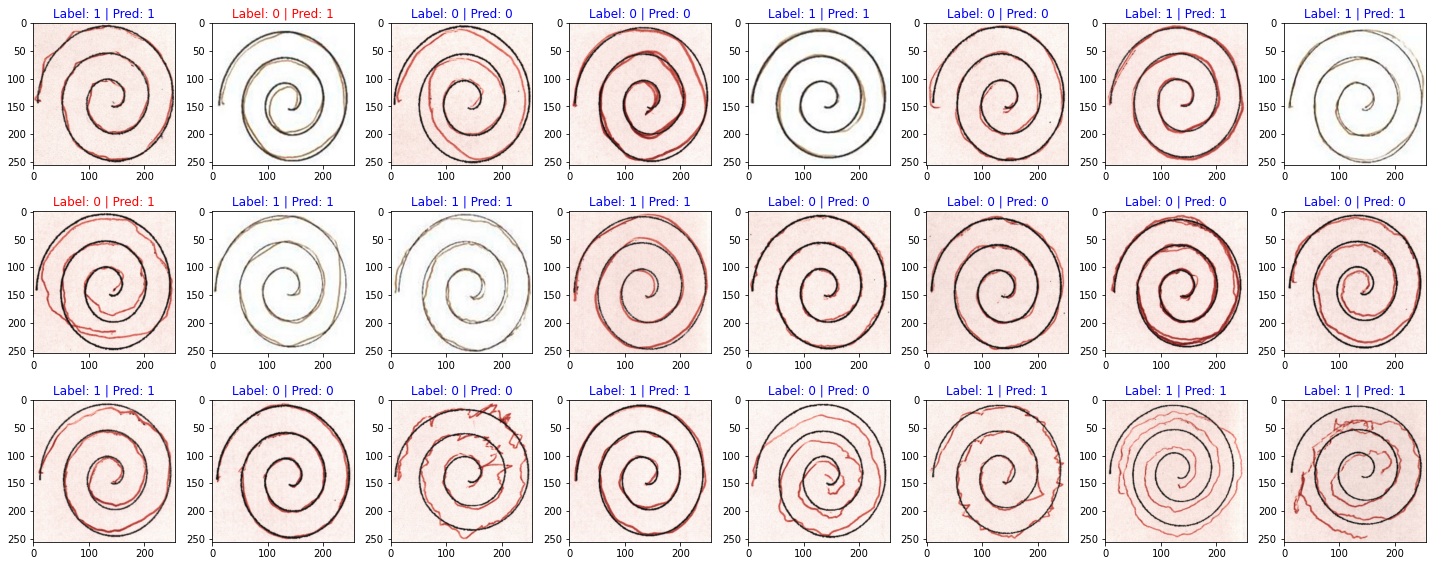

1/1 [==============================] - 0s 26ms/step


In [16]:
# plot the results
misClass_test, misClass_idx, predictions = plotMisclassImgs(testmodel, test_feat, np.argmax(test_lbls, axis=1), testArray)
# print(predictions)

In [ ]:
# -----------------------------------------
# -----------------------------------------
# -----------------------------------------
# -----------------------------------------
# other option for displaying accuracy and loss - plot them all overlaid
plt.figure(figsize=(10,10))
plt.title('Accuracies vs Epochs')
for i in range(k):
    plt.plot(model_history[i].history['accuracy'], label=i, color=color[i])
    plt.plot(model_history[i].history['val_accuracy'], label=i, linestyle= 'dashdot', color=color[i])
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
plt.title('Loss vs Epochs')
for i in range(k):
    plt.plot(model_history[i].history['loss'], label=i, color=color[i])
    plt.plot(model_history[i].history['val_loss'], label=i, linestyle= 'dashdot', color=color[i])
plt.legend()
plt.show()


In [13]:
# split training data into validation data as well
train_feat, val_feat, train_lbls, val_lbls = train_test_split(trainArray, trainLbls, test_size=0.2, random_state=10)
train_lbls_cat = tf.keras.utils.to_categorical(np.array(train_lbls))
val_lbls_cat   = tf.keras.utils.to_categorical(np.array(val_lbls))

In [3]:
model_top = tf.keras.models.load_model('20221201_rn50_test.h5')
# rn50 = VGG16(weights="imagenet", include_top=False, input_shape=(256,256,3))


In [4]:
model_top.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [7]:
input_layer = tf.keras.Input(shape=(256,256,3))
Layer1 = rn50(input_layer)
Layer2 = model_top.layers[0](Layer1)
output_layer = model_top.layers[1](Layer2)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)  # use the Adam optimizer and set an effective learning rate 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
trained_model = model.fit(np.array(train_feat), np.array(train_lbls_cat), batch_size=32, epochs=100, validation_data=(np.array(val_feat), np.array(val_lbls_cat)))

Epoch 1/100
3/6 [==============>...............] - ETA: 2:47 - loss: 7679.2837 - accuracy: 0.4583 

KeyboardInterrupt: 